# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [25]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

import tabulate  # Additionnal package to "pretty print"

print("OpenCV version", cv.__version__)
print("NumPy version", np.__version__)

%matplotlib inline

OpenCV version 4.12.0
NumPy version 2.2.6


9 images à traiter:


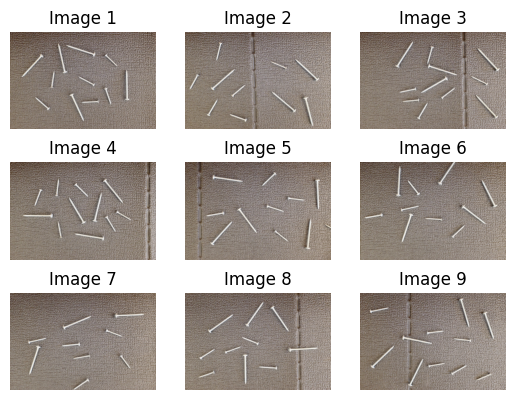

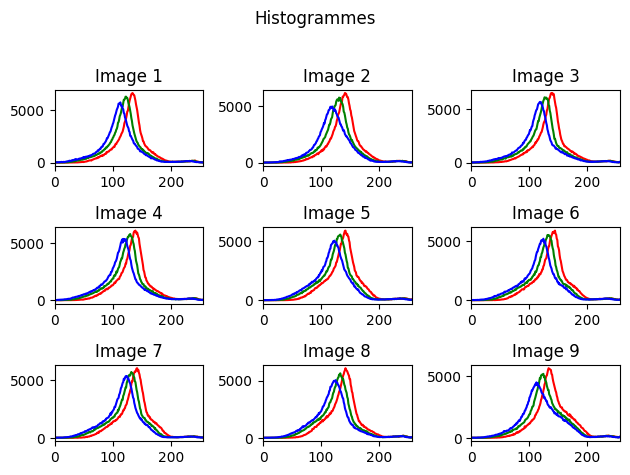

In [26]:
# Load images

image_filenames = os.listdir("photos_prob/")
image_filenames.sort()
assert image_filenames is not None
print(f"{len(image_filenames)} images à traiter:")

images: list[cv.typing.MatLike] = []

for filename in image_filenames:
    path = os.path.join("photos_prob/", filename)
    img = cv.imread(path)
    assert img is not None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)

plt.figure(0)
for index, image in enumerate(images):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image)
    plt.title(f"Image {index + 1}")
    plt.axis("off")
plt.show()

plt.figure(1)
plt.suptitle("Histogrammes")
channels = ("r", "g", "b")
for index, image in enumerate(images):
    plt.subplot(3, 3, index + 1)
    for i, col in enumerate(channels):
        hist = cv.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
        plt.title(f"Image {index + 1}")
plt.tight_layout(
    rect=(0.0, 0.0, 1.0, 0.96)
)  # Add vertical padding to avoid overlapping of elements
plt.show()


On observe certains motifs récurrents sur les histogrammes:

- Les courbes des canaux de couleurs possèdent une allure similaires (entre les canaux d'une image, et les canaux respectifs de toutes les images), et leur "pic" se situe entre `[110, 150]`;
- Une légère "bosse" apparaît entre `[210, 240]`.

Considérant que les vis n'occupent qu'une faible partie des images, on pose l'hypothèse que la "bosse" observée dans les histogrammes représentent les vis, et les "pics" représent (en majorité) la valeur moyenne du bruit qu'on cherche à éliminer (soit l'arrière-plan / le convoyeur).

Puisque les deux motifs observées occupent des plages de valeurs différentes, ça facilite le choix des valeurs pour les opérations de seuillage.

La répartition des valeurs des canaux semble suivre (la plupart du temps) une distribution normale (*i.e.* gaussienne). On pose donc l'hypothèse que le bruit est majoritairement de nature gaussienne, et une opération de flou gaussien devrait être adéquat pour une première "passe" de réduction du bruit. De plus, on peut calculer la moyenne et l'écart-type de l'intensité des images, qui faciliteront davantage la valeur des paramètres de certaines opérations.

# Paramètres Intrinsèques

Pour déterminer les valeurs $f_x$ et $f_y$ de la matrice $K$, on utilise les équivalences suivantes:

$$ \frac{f}{f_x} = \frac{largeur_{capteur}}{largeur_{image}} $$
$$ \frac{f}{f_y} = \frac{hauteur_{capteur}}{hauteur_{image}} $$


In [27]:
# Intrinsic parameters and intrinsic matrix

FOCAL_LENGTH = 23.0e-3  # m
IMG_WIDTH = 640  # px
IMG_HEIGHT = 427  # px
SENSOR_WIDTH = 23.4e-3  # m
SENSOR_HEIGHT = 15.6e-3  # m

fx = FOCAL_LENGTH * (IMG_WIDTH / SENSOR_WIDTH)  # px
fy = FOCAL_LENGTH * (IMG_HEIGHT / SENSOR_HEIGHT)  # px
cx = IMG_WIDTH / 2.0  # px
cy = IMG_HEIGHT / 2.0  # px
skew = 0.0  # px

K_tilde = np.array(
    [
        [fx, skew, cx, 0],
        [0, fy, cy, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ],
    dtype=np.float32,
)

print(f"Matrice intrinsèque K:\n{K_tilde}")

Matrice intrinsèque K:
[[629.0598   0.     320.       0.    ]
 [  0.     629.5513 213.5      0.    ]
 [  0.       0.       1.       0.    ]
 [  0.       0.       0.       1.    ]]


# Matrices de transformation et de projection

À partir de l'équation 2.64 du manuel de cours, on dérive l'équation pour calculer la matrice de projection en coordonnées homogènes:

$$ \tilde{P} = \tilde{T}_{c}\cdot\tilde{K}^{-1}, $$

où $\tilde{T}_{c}$ est la matrice de transformation en coordonnées homogènes du repère $\{C\}$ au repère $\{0\}$.

Puisque le plan $XY$ du repère $\{0\}$ est coplanaire avec le convoyeur, on dérive la distance verticale entre le convoyeur et la caméra:

$$ z_{c} \equiv z_{s} = \tilde{T}_{c, \{3, 4\}} $$


In [28]:
# 2. Homogenous extrinsic matrix (frame {C} to frame {0})

w_T_c_tilde = np.array(
    [
        [1, 0, 0, 0.500],
        [0, -1, 0, 0.200],
        [0, 0, -1, 0.282],
        [0, 0, 0, 1],
    ],
    dtype=np.float32,
)

print(f"Matrice extrinsèque w_T_c (Camera -> World):\n{w_T_c_tilde}\n")

# Homogenous projection matrix

w_P_c_tilde = w_T_c_tilde @ np.linalg.inv(K_tilde)  # Mathematical equivalent of P^-1

print(f"Matrice de projection complete (Camera -> World):\n{w_P_c_tilde}\n")

# Compute z_c
X_0 = 0  # m
Y_0 = 0  # m
Z_0 = 0  # m
z_c = (
    w_T_c_tilde[2, 3]
    + w_T_c_tilde[2, 0] * X_0
    + w_T_c_tilde[2, 1] * Y_0
    + w_T_c_tilde[2, 3] * Z_0
)  # m

print(f"z_c: {z_c:.3f} m")


Matrice extrinsèque w_T_c (Camera -> World):
[[ 1.     0.     0.     0.5  ]
 [ 0.    -1.     0.     0.2  ]
 [ 0.     0.    -1.     0.282]
 [ 0.     0.     0.     1.   ]]

Matrice de projection complete (Camera -> World):
[[ 0.00158967  0.         -0.50869566  0.5       ]
 [ 0.         -0.00158843  0.33913043  0.2       ]
 [ 0.          0.         -1.          0.282     ]
 [ 0.          0.          0.          1.        ]]

z_c: 0.282 m


# Procédure de résolution

On cherche à identifier et caractériser les vis dans les images. On sépare le problème en deux volets:

1. Isoler les vis dans l'image;
1. Déterminer la pose des vis dans l'image.

L'isolation des vis dans les images se fait par une chaîne de traitement d'image. Les paramètres de chaque étape de la chaîne sont déterminés de façon expérimentale (*i.e.* essai-erreur). La chaîne d'acquisition proposée implémente la logique suivante:

1. Réduire le bruit de l'arrière-plan, de sorte à l'uniformiser;
1. Appliquer un masque binaire à l'image afin de ségréger les vis et l'arrière-plan;
1. Appliquer des opérations morphologiques afin d'éliminer le bruit résiduel, et assurer que la forme originale des vis soit préservée (nécessaire pour une détection de contours idéale).

Pour déterminer la pose des vis dans l'image, une seconde chaîne de traitement implémente la logique suivante:

1. Détecter les contours des vis;
1. Filter les contours résultant du bruit résiduel;
1. Trouver la boîte englobante de chaque vis afin d'extraire leurs caractéristiques de position, de dimensions, et d'orientation;
1. Standardiser la notation des caractéristiques des vis;
1. Classifier les vis en fonction de leurs dimensions;
1. Convertir la position 2D dans l'image en coordonnées 3D.

Additionnellement, on dessine les boîtes englobantes (accompagnées de leur identifiant respectif) sur l'image originale afin de vérifier visuellement les résultats.


In [29]:
# Image processing pipeline

screws: list[dict[str, int | float | str]] = []
src_index: int = 0

### VVV SPECIFY SOURCE IMAGE HERE VVV
source = images[0]  # One-by-one processing for simplifying the problem
### ^^^ SPECIFY SOURCE IMAGE HERE ^^^

original = source.copy()
print(f"Image utilisée: {src_index + 1}")

float_values = np.float32(original)
mean = np.mean(float_values)
std_deviation = np.std(float_values)
print(f"Moyenne: {mean:.0f}, écart-type: {std_deviation:.0f}")


Image utilisée: 1
Moyenne: 121, écart-type: 31


À partir de la moyenne et de l'écart-type calculés de l'image, et de l'analyse des histogrammes des images, on conclut qu'une valeur de `sigmaX = 2.80` pour le flou gaussien permettra de réduire efficacement le bruit de l'image sans trop affecter la clarté des vis.

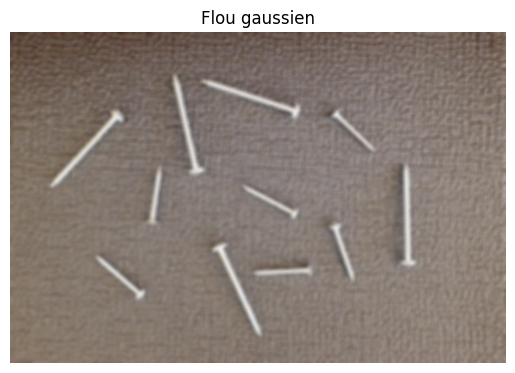

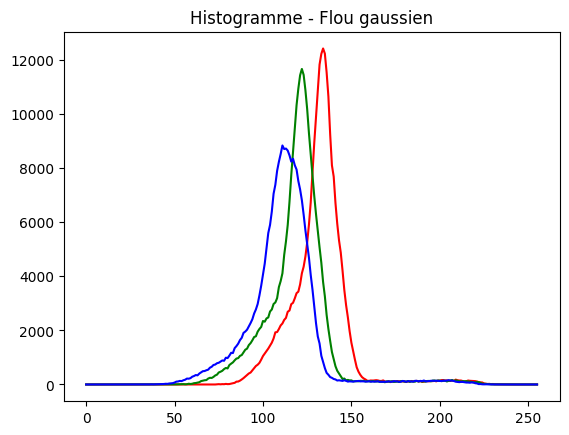

In [30]:
blurred = cv.GaussianBlur(original, (7, 7), 2.80)

plt.figure(0)
plt.imshow(blurred)
plt.title("Flou gaussien")
plt.axis("off")
plt.show()

channels = ("r", "g", "b")
plt.figure(1)
for index, color in enumerate(channels):
    hist = cv.calcHist([blurred], [index], None, [256], [0.0, 256.0])
    channels = ("r", "g", "b")
    plt.plot(hist, color=color)
    plt.title("Histogramme - Flou gaussien")
plt.show()


Sur l'histogramme, on observe:

- La "bosse" est toujours présente, mais sa plage de valeurs semble s'être déplacée entre `[185, 225]`;
- Les "pics" sont toujours présents, mais leur plage de valeur semble aussi s'être déplacé;
- La distinction entre la fin des "pics" et le début de la "bosse" semble être plus claire que sur l'image originale.

À partir des observations de l'histogramme de l'image en aval du flou gaussien, on pose l'hypothèse qu'une valeur de seuillage de `180` permettra d'éliminer la majorité de l'arrière-plan avec un masque binaire.


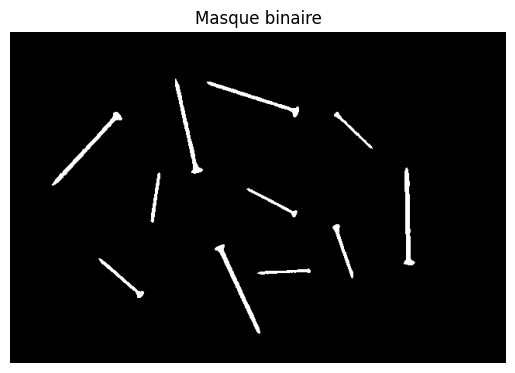

In [31]:
gray = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
_, threshold = cv.threshold(gray, 180.0, 255.0, cv.THRESH_BINARY)

plt.figure(0)
plt.imshow(threshold, "gray")
plt.title("Masque binaire")
plt.axis("off")
plt.show()


Tel qu'observé dans l'image du masque binaire, les vis sont bien isolées de l'arrière-plan, et de façon générale, leur forme originale est présevée. Le bruit résiduel est presque absent, mais certaines images possèdent plus de bruit résiduel, qui pourrait résulter en des "faux-positifs" lors de l'extraction des caractéristiques. De plus, on observe que le contour est en "dent de scie" à plusieurs endroits, et "adoucir" le contour des vis pourrait s'avérer bénéfique en aval. Dès lors, on pose l'hypothèse que des manipulations morphologiques auront les effets suivants sur les images:

- Le bruit résiduel sera presque entièrement éliminé;
- Le contour des vis sera adouci.


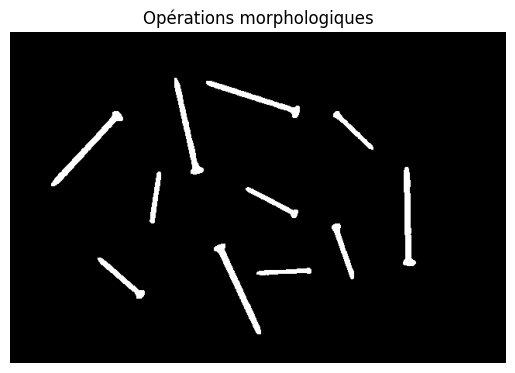

In [32]:
opening = cv.morphologyEx(
    threshold, cv.MORPH_OPEN, kernel=np.ones((1, 1), dtype=np.uint8)
)  # Remove "speckles" (residual noise)
dilated = cv.dilate(
    opening, kernel=np.ones((3, 3), dtype=np.uint8), iterations=1
)  # Smoothen the contour of screws

plt.figure(0)
plt.imshow(dilated, "gray")
plt.title("Opérations morphologiques")
plt.axis("off")
plt.show()


Tel qu'observé dans l'image des opérations morphologiques, le bruit résiduel est pratiquement absent, et est considéré négligeable: un filtre basé sur la superficie d'un "blob" éliminera la possibilité d'un "faux-positif" dans l'extraction des caractéristiques. Malheureusement, le contour des vis n'est pas vraiment "adouci". Toutefois, l'épaisseur des vis semble avoir augmenté. On pose l'hypothèse que l'effet observé permettra de distinguer davantage les vis du bruit résiduel, alors la manipulation est retenue.

Les contours détectés des images sont filtrer en fonction de leur superficie. Les bornes inférieures et supérieures du filtre ont été déterminé à partir des hypothèses suivantes:

- La superficie d'une agglomération représentant du bruit résiduel ne dépasse pas 100 pixels;
- La superficie totale d'une vis, en considérant sa dilatation après transformation morphologiqe, sera inférieure à 2 % de la superficie totale de l'image, soit environ 5000 pixels.

En ce qui concerne la classification des vis, on utilise la hauteur de la boîte englobante du contour détecté comme paramètre. La valeur du seuil de distinction entre une vis courte et une vis longue a été déterminée expérimentalement.


In [33]:
# Caracteristics extraction

contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

MIN_SCREW_AREA = 100  # px
MAX_SCREW_AREA = 5000  # px
HEIGHT_THRESHOLD = 100  # px

results = []
screw_id: int = 0

for contour in contours:
    area = cv.contourArea(contour)
    if area < MIN_SCREW_AREA or area > MAX_SCREW_AREA:
        continue

    rect = cv.minAreaRect(contour)
    (c_u, c_v), (width, height), theta = rect

    # Draw bounding box and id
    bbox = cv.boxPoints(rect)
    bbox = np.intp(bbox)  # Convert box points to integer type for drawing
    cv.drawContours(original, [bbox], 0, (0, 0, 255), 2)  # type: ignore
    cv.putText(
        original,
        str(screw_id),
        (int(c_u) - 5, int(c_v) - 5),
        cv.FONT_HERSHEY_SIMPLEX,
        1.0,
        (255, 0, 0),
        3,
        cv.LINE_AA,
    )

    # Standardise bounding box notation
    if width > height:
        width, height = height, width
        theta += 90
    theta = (theta + 90) % 180
    theta = (360 - theta) % 180

    screw_type = "courte"
    if height > HEIGHT_THRESHOLD:
        screw_type = "longue"

    # Screen space to camera space
    z_screen = z_c  # px?
    x_screen = c_u * z_screen  # px^2?
    y_screen = c_v * z_screen  # px^2?
    X_s_prime = np.array([x_screen, y_screen, z_screen, 1], dtype=np.float32)

    # Camera space to world space
    p_w = w_P_c_tilde @ X_s_prime
    x_0, y_0, z_0, _ = p_w

    results.append(
        {
            "id": screw_id,
            "type": screw_type,
            "X": x_0,
            "Y": y_0,
            "Z": z_0,
            "theta": theta,
        }
    )
    screw_id += 1


# Note sur le calcul de l'orientation

Le calcul de l'orientation des vis est effectué à partir de la boîte englobante. Toutefois, tel qu'observé dans les images annotées, l'orientation des boîtes diffère un peu de l'orientation des vis: il y a donc une certaine tolérance associée aux valeurs de l'orientation (de l'ordre de quelques degrés).

Une stratégie qui résulterait en des valeurs plus justes serait d'utiliser la transformée de Hough pour identifier les lignes "directrices" dans l'image, qui sont parallèles aux vis. Cette stratégie possède aussi des limites: plusieurs lignes peuvent appartenir à la même vis. Les résultats de la transformée nécessite donc d'être agglomérer (*clustering*).

Expérimentalement, des paramètres de l'algorithme d'agglomération qui permettent d'obtenir un ratio $1:1$ (c.à.d. une ligne par vis) n'ont pas été identifiés. Considérant que l'agglomération des lignes est en dehors de la portée du cours, les résultats produits par l'algorithme d'agglomération ne sont pas utilisés. Dès lors, cette stratégie n'est pas implémentée dans ce code.


Image 1:

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)
----  ------  -------  -------  -------  -------------
   0  courte    0.515    0.157    0.000          2.121
   1  courte    0.420    0.153    0.000        142.206
   2  longue    0.488    0.147    0.000        112.810
   3  courte    0.549    0.169    0.000        106.074
   4  courte    0.507    0.197    0.000        154.654
   5  courte    0.441    0.200    0.000         81.674
   6  longue    0.587    0.189    0.000         90.000
   7  courte    0.556    0.239    0.000        138.289
   8  longue    0.400    0.228    0.000         44.648
   9  longue    0.496    0.257    0.000        164.055
  10  longue    0.460    0.242    0.000        100.713



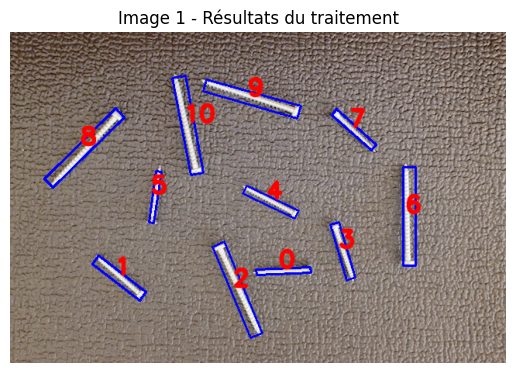

In [34]:
# Display results

print(f"Image {src_index + 1}:\n")
print(
    tabulate.tabulate(
        [
            [
                screw["id"],
                screw["type"],
                screw["X"],
                screw["Y"],
                screw["Z"],
                screw["theta"],
            ]
            for screw in results
        ],
        headers=[
            "id",
            "Type",
            "X (m)",
            "Y (m)",
            "Z (m)",
            "theta (deg)",
        ],
        floatfmt=".3f",
    )
)
print()

plt.figure(0)
plt.imshow(original)
plt.title(f"Image {src_index + 1} - Résultats du traitement")
plt.axis("off")
plt.show()


# Analyse des résultats

On observe que la chaîne de traitement d'images produit des résultats qui sont, de façon générale, adéquats pour répondre au problème posé. Toutefois, la faiblesse principale notée de la chaîne de traitement est l'utilisation de la boîte englobante pour déterminer l'orientation des vis. Effectivement, tel qu'observé sur l'image annotée, la boîte englobante n'est pas parfaitement alignée avec la vis, ce qui résulte en une erreur sur l'orientation. Expérimentalement, la borne supérieure de cette erreur a été évaluée à un ordre de $\pm 10\degree$, ce qui n'est pas négligeable. Pour mitiger cette erreur, on suggère d'augmenter l'ouverture du préhenseur, de sorte que la plage de valeurs de l'orientation d'une vis soit entièrement couverte.

L'autre faiblesse identifiée de la chaîne de traitement d'images est le manque de diversité dans les échantillons utilisés pour convevoir la chaîne: on pourrait considérer cette faiblesse comme l'analogue du sur-entraînement d'un modèle d'intelligence articifielle. Certes, la performance de la chaîne sur les échantillons fournis est adéquate, mais une image où des débris s'entremêlent avec les vis pourrait résulter en une performance médiocre. Autrement dit, la chaîne de traitement n'est pas considérée robuste.


# Modifications pour le traitement par lots

Tel qu'illustré dans les résultats affichés plus bas, la moyenne et l'écart-type est différente pour chaque image, et l'utilisation d'une valeur de `sigmaX = 2.80` pour le flou gaussien n'est pas appropriée pour les images avec un écart-type plus élevé. Dès lors, on conclut qu'une stratégie plus efficace est de déterminer dynamiquement la valeur de `sigmaX` en fonction des paramètres de la distribution normale de l'image originale. L'équation utilisée est:

$$\sigma_{x} = \frac{210 - \mu}{\sigma},$$

où $\mu$ et $\sigma$ sont la moyenne et l'écart-type calculés de l'image originale. La valeur $210$ provient de l'analyse des histogrammes des images originales, où la plage des valeurs des "bosses" se situe entre $[210, 240]$. On pose l'hypothèse qu'en utilisant la borne inférieure de la plage de valeurs, on réduit considérablement l'effet du flou gaussien sur les vis tout en maximisant l'effet sur le bruit.


Paramètres de distribution normale des images originales
  Image    moyenne    écart-type    'sigmaX' visé
-------  ---------  ------------  ---------------
      1        120            30            2.883
      2        129            29            2.704
      3        125            31            2.662
      4        124            32            2.649
      5        127            31            2.613
      6        127            32            2.567
      7        126            30            2.708
      8        127            31            2.644
      9        129            32            2.467



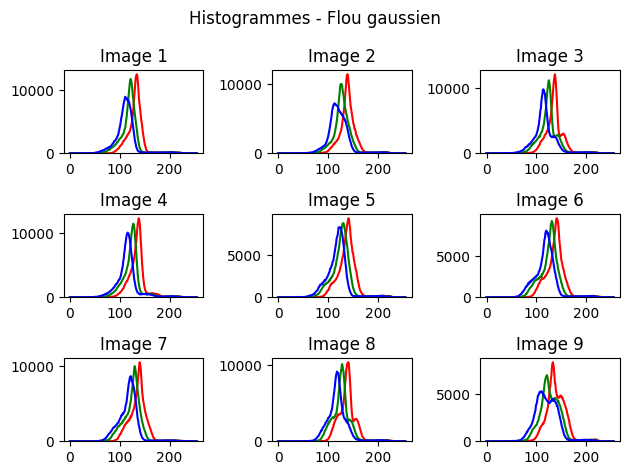

Tableau des résultats
Image 1:

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)
----  ------  -------  -------  -------  -------------
   0  courte    0.515    0.157    0.000          2.121
   1  courte    0.420    0.153    0.000        142.206
   2  longue    0.488    0.147    0.000        112.810
   3  courte    0.549    0.169    0.000        106.074
   4  courte    0.507    0.197    0.000        154.933
   5  courte    0.441    0.200    0.000         81.674
   6  longue    0.587    0.189    0.000         90.000
   7  courte    0.555    0.238    0.000        134.341
   8  longue    0.400    0.228    0.000         44.648
   9  longue    0.496    0.257    0.000        164.055
  10  longue    0.460    0.242    0.000        100.713

Image 2:

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)
----  ------  -------  -------  -------  -------------
   0  courte    0.461    0.126    0.000        163.465
   1  courte    0.410    0.146    0.000         62.281
   2  longue    0.600 

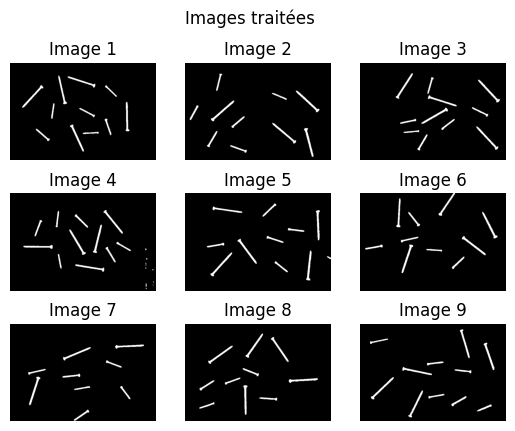

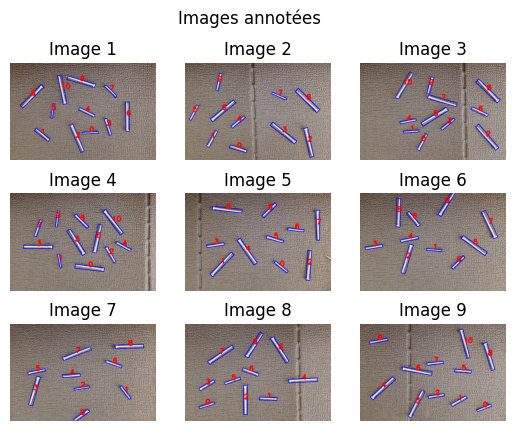

In [35]:
# Batch processing pipeline

normal_distribution_params: list[tuple[int, int, float]] = []
blurred_histrograms: list[list[cv.typing.MatLike]] = []
processed_images: list[cv.typing.MatLike] = []
all_results: list[list[dict[str, int | float | str]]] = []

for index, image in enumerate(images):
    original = image.copy()

    # Compute normal distribution parameters
    float_values = np.float32(original)
    mean = np.mean(float_values)
    std_deviation = np.std(float_values)
    target_sigma = float((210.0 - mean) / std_deviation)
    normal_distribution_params.append((int(mean), int(std_deviation), target_sigma))

    # Image transformations

    blurred = cv.GaussianBlur(original, (7, 7), target_sigma)
    histograms: list[cv.typing.MatLike] = []
    channels = ("r", "g", "b")
    for jj, _ in enumerate(channels):
        hist = cv.calcHist([blurred], [jj], None, [256], [0, 256])
        histograms.append(hist)
    blurred_histrograms.append(histograms)

    gray = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
    _, threshold = cv.threshold(gray, 180.0, 255.0, cv.THRESH_BINARY)

    opening = cv.morphologyEx(
        threshold, cv.MORPH_OPEN, kernel=np.ones((1, 1), dtype=np.uint8)
    )
    dilated = cv.dilate(opening, kernel=np.ones((3, 3), dtype=np.uint8), iterations=1)
    processed_images.append(dilated)

    # Caracteristics extraction

    contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    MIN_SCREW_AREA = 100  # px
    MAX_SCREW_AREA = 5000  # px
    HEIGHT_THRESHOLD = 100  # px

    results: list[dict[str, int | float | str]] = []
    screw_id: int = 0

    for contour in contours:
        area = cv.contourArea(contour)
        if area < MIN_SCREW_AREA or area > MAX_SCREW_AREA:
            continue

        rect = cv.minAreaRect(contour)
        (c_u, c_v), (width, height), theta = rect

        # Draw bounding box and id
        bbox = cv.boxPoints(rect)
        bbox = np.intp(bbox)  # Convert box points to integer type for drawing
        cv.drawContours(image, [bbox], 0, (0, 0, 255), 2)  # type: ignore
        cv.putText(
            image,
            str(screw_id),
            (int(c_u) - 5, int(c_v) - 5),
            cv.FONT_HERSHEY_SIMPLEX,
            1.0,
            (255, 0, 0),
            3,
            cv.LINE_AA,
        )

        # Standardise bounding box notation
        if width > height:
            width, height = height, width
            theta += 90
        theta = theta + 90  # ∈ [0, 180[, CW positive
        theta = (360 - theta) % 180  # Convert to CCW positive

        screw_type = "courte"
        if height > HEIGHT_THRESHOLD:
            screw_type = "longue"

        # Screen space to camera space
        z_screen = z_c  # px?
        x_screen = c_u * z_screen  # px^2?
        y_screen = c_v * z_screen  # px^2?
        X_s_prime = np.array([x_screen, y_screen, z_screen, 1], dtype=np.float32)

        # Camera space to world space
        p_w = w_P_c_tilde @ X_s_prime
        x_0, y_0, z_0, _ = p_w

        results.append(
            {
                "id": screw_id,
                "type": screw_type,
                "X": x_0,
                "Y": y_0,
                "Z": z_0,
                "theta": theta,
            }
        )
        screw_id += 1

    all_results.append(results)


# Display intermediary results

title = "Paramètres de distribution normale des images originales"
print(f"{title}\n{'=' * len(title)}")
print(
    tabulate.tabulate(
        [
            [index + 1, params[0], params[1], params[2]]
            for index, params in enumerate(normal_distribution_params)
        ],
        headers=["Image", "moyenne", "écart-type", "'sigmaX' visé"],
        floatfmt=".3f",
    )
)
print()

plt.figure(0)
plt.suptitle("Histogrammes - Flou gaussien")
for index, histogram in enumerate(blurred_histrograms):
    plt.subplot(3, 3, index + 1)
    channels = ("r", "g", "b")
    for i, col in enumerate(channels):
        plt.plot(histogram[i], color=col)
        plt.gca().set_ylim(bottom=0)
        plt.tight_layout()
    plt.title(f"Image {index + 1}")
plt.show()

# Display results

title = "Tableau des résultats"
print(f"{title}\n{'=' * len(title)}")
for index, _ in enumerate(images):
    print(f"Image {index + 1}:\n")
    print(
        tabulate.tabulate(
            [
                [
                    screw["id"],
                    screw["type"],
                    screw["X"],
                    screw["Y"],
                    screw["Z"],
                    screw["theta"],
                ]
                for screw in all_results[index]
            ],
            headers=[
                "id",
                "Type",
                "X (m)",
                "Y (m)",
                "Z (m)",
                "theta (deg)",
            ],
            floatfmt=".3f",
        )
    )
    print()

plt.figure(1)
plt.suptitle("Images traitées")
for index, image in enumerate(processed_images):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image, "gray")
    plt.title(f"Image {index + 1}")
    plt.axis("off")
plt.show()

plt.figure(2)
plt.suptitle("Images annotées")
for index, image in enumerate(images):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image)
    plt.title(f"Image {index + 1}")
    plt.axis("off")
plt.show()

# Pipeline alternatif

Un pipeline alternatif plus simple a été testé. La chaîne consistait en un filtre bilatéral avec la signature `bilateralFilter(original, d=9, sigmaColor=75.0, sigmaSapce=75.0)`, suivie de l'opération de seuillage utilisée dans la chaîne implémentée ci-dessus (même paramètres). Les observations suivantes ont été réalisées:

- Le bruit résiduel est moindre;
- La boîte englobante est généralement mieux centrée sur les vis, et l'orientation est ainsi plus précise;
- La tête des vis, plus particulièrement les vis courtes, est parfois filtrée de l'image, et la boîte englobante ne couvre pas ces têtes.

> *N.B.* Les valeurs des paramètres du filtre bilatéral ont été déterminés expérimentalement (en termes grossiers: "au *feeling*"), et ne possèdent pas de justification "logique".

Les deux chaînes évaluées offrent un compromis différent. Les performances des deux chaînes sont jugées adéquates (et similaires) pour répondre au besoin du problème posé. Certes, le pipeline alternatif est plus simple et plus élégant, mais on pose l'hypothèse qu'en raison de sa simplicité, il est moins robuste.


9 images à traiter:
Paramètres de distribution normale des images originales
Image    moyenne    écart-type    'sigmaX' visé
-------  ---------  ------------  ---------------



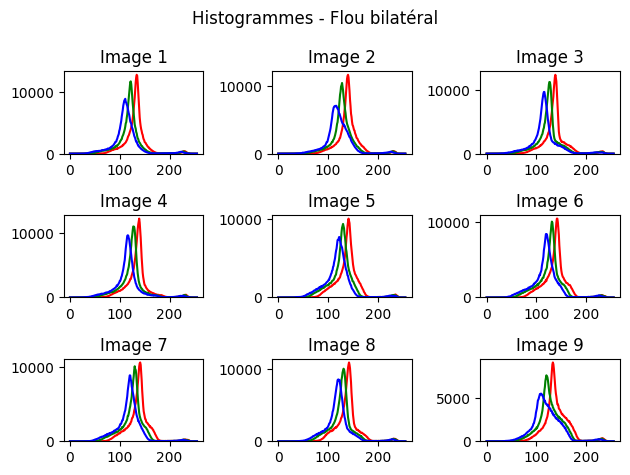

Tableau des résultats
Image 1:

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)
----  ------  -------  -------  -------  -------------
   0  courte    0.514    0.157    0.000          3.691
   1  courte    0.420    0.155    0.000        135.000
   2  longue    0.488    0.146    0.000        112.270
   3  courte    0.551    0.169    0.000        111.297
   4  courte    0.506    0.198    0.000        155.480
   5  courte    0.441    0.200    0.000         79.778
   6  longue    0.588    0.189    0.000         89.053
   7  longue    0.399    0.228    0.000         44.653
   8  courte    0.556    0.239    0.000        138.900
   9  longue    0.495    0.257    0.000        164.659
  10  longue    0.459    0.243    0.000        100.649

Image 2:

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)
----  ------  -------  -------  -------  -------------
   0  courte    0.461    0.128    0.000        157.306
   1  courte    0.412    0.146    0.000         56.070
   2  longue    0.602 

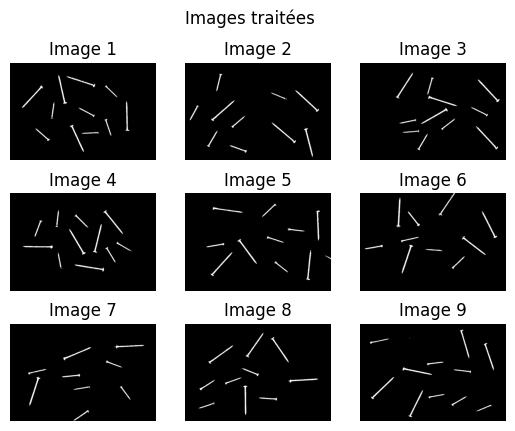

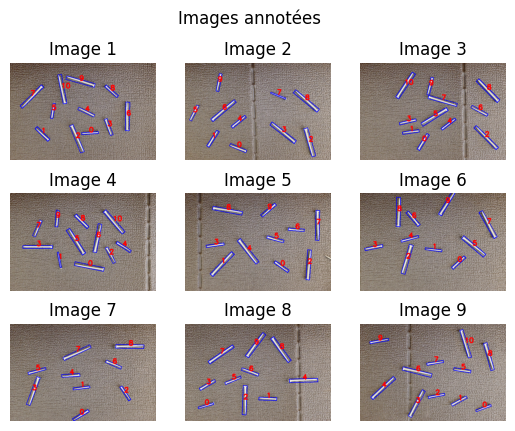

In [36]:
# Alternative processing pipeline

# Reload images (to avoid annotating over the images from the previous pipeline)

image_filenames = os.listdir("photos_prob/")
image_filenames.sort()
assert image_filenames is not None
print(f"{len(image_filenames)} images à traiter:")

images: list[cv.typing.MatLike] = []

for filename in image_filenames:
    path = os.path.join("photos_prob/", filename)
    img = cv.imread(path)
    assert img is not None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)

normal_distribution_params: list[tuple[int, int, float]] = []
blurred_histrograms: list[list[cv.typing.MatLike]] = []
processed_images: list[cv.typing.MatLike] = []
all_results: list[list[dict[str, int | float | str]]] = []

for index, image in enumerate(images):
    original = image.copy()

    # Image transformations
    
    blurred = cv.bilateralFilter(original, 9, 75.0, 75.0)
    histograms: list[cv.typing.MatLike] = []
    channels = ("r", "g", "b")
    for jj, _ in enumerate(channels):
        hist = cv.calcHist([blurred], [jj], None, [256], [0, 256])
        histograms.append(hist)
    blurred_histrograms.append(histograms)

    gray = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
    _, threshold = cv.threshold(gray, 195.0, 255.0, cv.THRESH_BINARY)
    processed_images.append(threshold)

    # Caracteristics extraction

    contours, _ = cv.findContours(threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    MIN_SCREW_AREA = 100  # px
    MAX_SCREW_AREA = 5000  # px
    HEIGHT_THRESHOLD = 100  # px

    results: list[dict[str, int | float | str]] = []
    screw_id: int = 0

    for contour in contours:
        area = cv.contourArea(contour)
        if area < MIN_SCREW_AREA or area > MAX_SCREW_AREA:
            continue

        rect = cv.minAreaRect(contour)
        (c_u, c_v), (width, height), theta = rect

        # Draw bounding box and id
        bbox = cv.boxPoints(rect)
        bbox = np.intp(bbox)  # Convert box points to integer type for drawing
        cv.drawContours(image, [bbox], 0, (0, 0, 255), 2)  # type: ignore
        cv.putText(
            image,
            str(screw_id),
            (int(c_u) - 5, int(c_v) - 5),
            cv.FONT_HERSHEY_SIMPLEX,
            1.0,
            (255, 0, 0),
            3,
            cv.LINE_AA,
        )

        # Standardise bounding box notation
        if width > height:
            width, height = height, width
            theta += 90
        theta = theta + 90  # ∈ [0, 180[, CW positive
        theta = (360 - theta) % 180  # Convert to CCW positive

        screw_type = "courte"
        if height > HEIGHT_THRESHOLD:
            screw_type = "longue"

        # Screen space to camera space
        z_screen = z_c  # px?
        x_screen = c_u * z_screen  # px^2?
        y_screen = c_v * z_screen  # px^2?
        X_s_prime = np.array([x_screen, y_screen, z_screen, 1], dtype=np.float32)

        # Camera space to world space
        p_w = w_P_c_tilde @ X_s_prime
        x_0, y_0, z_0, _ = p_w

        results.append(
            {
                "id": screw_id,
                "type": screw_type,
                "X": x_0,
                "Y": y_0,
                "Z": z_0,
                "theta": theta,
            }
        )
        screw_id += 1

    all_results.append(results)


# Display intermediary results

title = "Paramètres de distribution normale des images originales"
print(f"{title}\n{'=' * len(title)}")
print(
    tabulate.tabulate(
        [
            [index + 1, params[0], params[1], params[2]]
            for index, params in enumerate(normal_distribution_params)
        ],
        headers=["Image", "moyenne", "écart-type", "'sigmaX' visé"],
        floatfmt=".3f",
    )
)
print()

plt.figure(0)
plt.suptitle("Histogrammes - Flou bilatéral")
for index, histogram in enumerate(blurred_histrograms):
    plt.subplot(3, 3, index + 1)
    channels = ("r", "g", "b")
    for i, col in enumerate(channels):
        plt.plot(histogram[i], color=col)
        plt.gca().set_ylim(bottom=0)
        plt.tight_layout()
    plt.title(f"Image {index + 1}")
plt.show()

# Display results

title = "Tableau des résultats"
print(f"{title}\n{'=' * len(title)}")
for index, _ in enumerate(images):
    print(f"Image {index + 1}:\n")
    print(
        tabulate.tabulate(
            [
                [
                    screw["id"],
                    screw["type"],
                    screw["X"],
                    screw["Y"],
                    screw["Z"],
                    screw["theta"],
                ]
                for screw in all_results[index]
            ],
            headers=[
                "id",
                "Type",
                "X (m)",
                "Y (m)",
                "Z (m)",
                "theta (deg)",
            ],
            floatfmt=".3f",
        )
    )
    print()

plt.figure(1)
plt.suptitle("Images traitées")
for index, image in enumerate(processed_images):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image, "gray")
    plt.title(f"Image {index + 1}")
    plt.axis("off")
plt.show()

plt.figure(2)
plt.suptitle("Images annotées")
for index, image in enumerate(images):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image)
    plt.title(f"Image {index + 1}")
    plt.axis("off")
plt.show()